In [1]:
!pip install opencv-python matplotlib imageio gdown tensorflow

  Using cached gdown-4.7.1-py3-none-any.whl (15 kB)
  Using cached protobuf-3.19.6-cp39-cp39-win_amd64.whl (895 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.1
    Uninstalling protobuf-3.20.1:
      Successfully uninstalled protobuf-3.20.1
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-models-official 2.12.0 requires gin-config, which is not installed.
tf-models-official 2.12.0 requires google-api-python-client>=1.6.7, which is not installed.
tf-models-official 2.12.0 requires immutabledict, which is not installed.
tf-models-official 2.12.0 requires kaggle>=1.3.9, which is not installed.
tf-models-official 2.12.0 requires oauth2client, which is not installed.
tf-models-official 2.12.0 requires opencv-python-headless, which is not installed.
tf-models-official 2.12.0 requires py-cpuinfo>=3.3.0, which is not installed.
tf-models-official 2.12.0 requires pycocotools, which is not installed.
tf-models-official 2.12.0 requires seqeval, which is not installed.
tf-models-official 2.12.0 requires tensorflow-addons, which is not installed.
tf-models-official 2.12.0 requires tensorflow-datasets, which 

In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [3]:
def load_video(path:str) -> List[float]:

  cap = cv2.VideoCapture(path)
  frames =[]
  for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
    ret, frame = cap.read()
    frame = tf.image.rgb_to_grayscale(frame)
    frames.append(frame[190:236,80:220,:])
  cap.release()


  mean = tf.math.reduce_mean(frames)
  std = tf.math.reduce_std(tf.cast(frames,tf.float32))
  return tf.cast((frames-mean), tf.float32) / std

In [4]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [5]:
char_to_num = tf.keras.layers.StringLookup(vocabulary = vocab , oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary = char_to_num.get_vocabulary(),oov_token="",invert=True
)

print(
    f"The vocabulary is : {char_to_num.get_vocabulary()}"
    f"(size = {char_to_num.vocabulary_size()})"
)

The vocabulary is : ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '](size = 40)


In [6]:
char_to_num(['n','i','c'])

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([14,  9,  3], dtype=int64)>

In [7]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [8]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [9]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [10]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [11]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

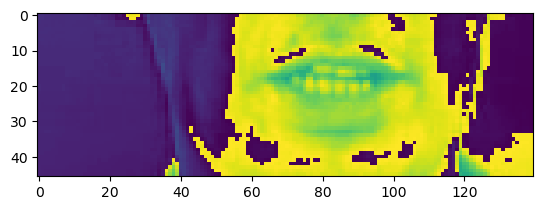

In [12]:
plt.imshow(frames[40])

In [13]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [14]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [15]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

2. Create Data Pipeline

In [16]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [18]:
len(test)

50

In [19]:
frames, alignments = data.as_numpy_iterator().next()

In [20]:
len(frames)

2

In [22]:
sample = data.as_numpy_iterator()
val = sample.next(); val[0]

array([[[[[0.94503623],
          [1.0206392 ],
          [0.6804261 ],
          ...,
          [0.26461014],
          [0.2268087 ],
          [0.2268087 ]],

         [[0.86943334],
          [1.0206392 ],
          [0.34021306],
          ...,
          [0.26461014],
          [0.2268087 ],
          [0.2268087 ]],

         [[1.4742565 ],
          [1.4364551 ],
          [1.1340435 ],
          ...,
          [0.34021306],
          [0.2268087 ],
          [0.2268087 ]],

         ...,

         [[1.0584406 ],
          [1.0584406 ],
          [1.0584406 ],
          ...,
          [0.        ],
          [9.63937   ],
          [9.63937   ]],

         [[1.0206392 ],
          [1.0206392 ],
          [1.0206392 ],
          ...,
          [0.        ],
          [9.63937   ],
          [9.63937   ]],

         [[1.0206392 ],
          [1.0206392 ],
          [1.0206392 ],
          ...,
          [0.        ],
          [9.63937   ],
          [9.601568  ]]],


        [[[1.0206

In [23]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)

Lossy conversion from float32 to uint8. Range [0.0, 9.63936996459961]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.63936996459961]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.63936996459961]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.63936996459961]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.63936996459961]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.63936996459961]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.63936996459961]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0.0, 9.63936996459961]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.63936996459961]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.63936996459961]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.63936996459961]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.63936996459961]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.63936996459961]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.63936996459961]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

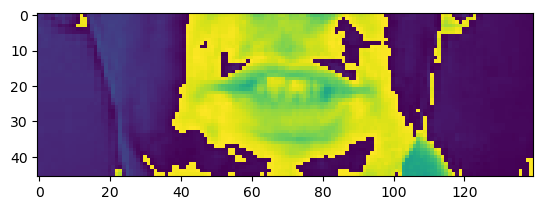

In [24]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][35])

In [25]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue with y seven soon'>

In [26]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [27]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [28]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))


In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [30]:
yhat = model.predict(val[0])

1/1 [==============================] - 5s 5s/step


In [31]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyuu'>

In [32]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyuu'>

In [33]:
model.input_shape

(None, 75, 46, 140, 1)

In [34]:
model.output_shape

(None, 75, 41)